# Importing libraries and setting the device.

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import KFold

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
device

device(type='cuda')

# Inspecting the data.

In [6]:
folders = ["test", "train", "valid"]
inner_folders = ["fake", "real"]

total_fake = 0
total_real = 0

for i in range(len(folders)):
  for j in range(len(inner_folders)):
    x = os.listdir(f"/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/{folders[i]}/{inner_folders[j]}")
    print(f"Length of {inner_folders[j]} images in {folders[i]} : {len(x)}")
    if(inner_folders[j] == "real"):
      total_real += len(x)
    else:
      total_fake += len(x)

print(f"Total Number of Real images in dataset: {total_real}")

print(f"Total Number of Fake images in dataset: {total_fake}")

Length of fake images in test : 10000
Length of real images in test : 10000
Length of fake images in train : 50000
Length of real images in train : 50000
Length of fake images in valid : 10000
Length of real images in valid : 10000
Total Number of Real images in dataset: 70000
Total Number of Fake images in dataset: 70000


In [7]:
data_dir = "/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake"

# Viewing the first 3 real and fake numbers.

Displaying the first 3 real images:


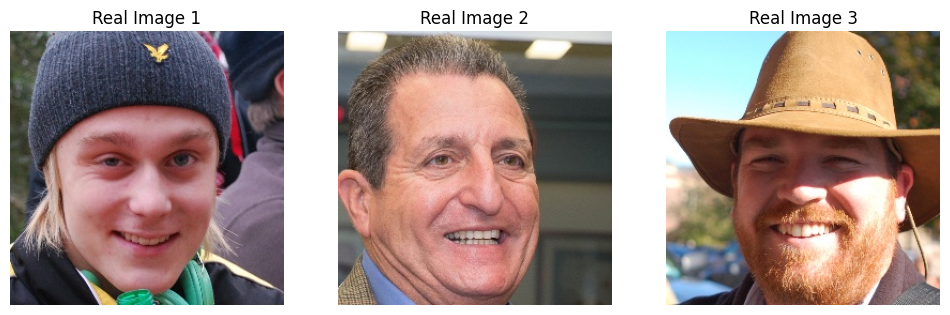

Displaying the first 3 fake images:


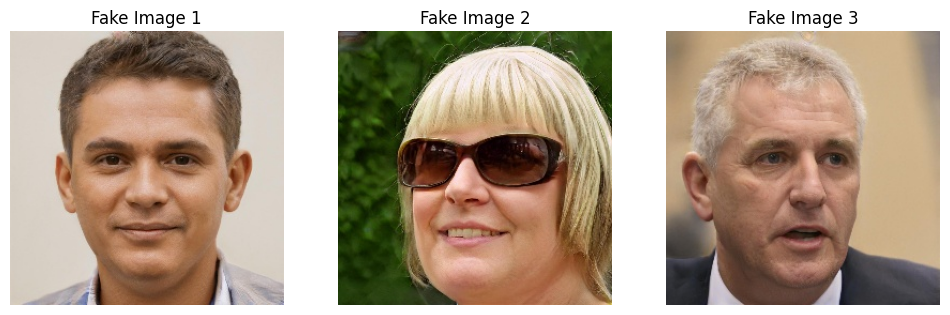

In [6]:
from PIL import Image
def show_first_images(data_dir, class_type, num_images=3):

    folder_path = os.path.join(data_dir, "train", class_type)
    image_files = os.listdir(folder_path)[:num_images]

    plt.figure(figsize=(12, 4))
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(folder_path, image_file)
        image = Image.open(image_path).convert("RGB")
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(f"{class_type.capitalize()} Image {i + 1}")
        plt.axis("off")
    plt.show()

print("Displaying the first 3 real images:")
show_first_images(data_dir, "real")

print("Displaying the first 3 fake images:")
show_first_images(data_dir, "fake")

# **Data Transformation**

Applying the transformation on train, test and validate data.\
Resizing the input images to **64 x 64** for lower computation.

In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
data_dirs = {
    'train': os.path.join(data_dir, 'train'),
    'val': os.path.join(data_dir, 'valid'),
    'test': os.path.join(data_dir, 'test')
}

# Dataset Loading

In [11]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_dataset = ImageFolder(root=data_dirs['train'], transform=data_transforms['train'])
val_dataset = ImageFolder(root=data_dirs['val'], transform=data_transforms['val'])
test_dataset = ImageFolder(root=data_dirs['test'], transform=data_transforms['test'])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid

def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Unnormalize the image
    img = np.clip(img, 0, 1)  # Clip values to [0, 1]
    plt.imshow(img)
    plt.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    image, label = train_dataset[i] 
    axs[i].imshow(image.permute(1, 2, 0).numpy())  # Display the image (transpose the dimensions)
    axs[i].set_title(f"Label: {label}")
    axs[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

# 0 => fake // 1 => real

# Data Loading and Combination

This section creates PyTorch `DataLoader` objects to handle efficient data batching and loading for training, validation, and testing.\
Additionally, it combines the training and validation datasets into a single dataset for Kfolds used later in the notebook.

In [12]:
from torch.utils.data import ConcatDataset
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True, pin_memory=True,num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=200, shuffle=False, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=2)
combined_loader = DataLoader(ConcatDataset([train_dataset, val_dataset]),batch_size=200,shuffle=True, pin_memory=True,num_workers=2)
conc_dataset=ConcatDataset([train_dataset, val_dataset])

In [13]:
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}
class_names = train_dataset.classes

print("Dataset Sizes:", dataset_sizes)

print("Class Names:", class_names)

Dataset Sizes: {'train': 100000, 'val': 20000, 'test': 20000}
Class Names: ['fake', 'real']


# Modified VGG16 Model

The SmallVGG model leverages the pre-trained VGG16 architecture for transfer learning, reusing its feature extraction layers to save computational resources and training time.\
The classifier is redesigned to handle binary classification by replacing the original 1,000-class output with a single-node output, tailored for the deepfake detection task.\
Input images are resized to 64×64 to reduce computational load and adapt to dataset constraints, while maintaining enough detail for feature extraction.\
Flattening the feature map output ensures compatibility with the custom fully connected layers, optimizing the model for your specific application.

In [14]:
import torch.nn as nn

class SmallVGG(nn.Module):
    def __init__(self):
      super(SmallVGG, self).__init__()
      vgg = models.vgg16(weights='IMAGENET1K_V1')
      self.features = vgg.features
      self.classifier = nn.Sequential(
          nn.Linear(512 * 2 * 2, 4096),  # Input size adjusted for 64x64 images
          nn.ReLU(True),
          nn.Dropout(),
          nn.Linear(4096, 4096),
          nn.ReLU(True),
          nn.Dropout(),
          nn.Linear(4096, 1),  # Replace num_classes with your target classes
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Objective function for the SmallVGG model

In [37]:
def objective(trial):
    
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)

    
    model = SmallVGG()
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    print(f"Trial: {trial.number} with learning rate: {lr}")

    # Training loop
    model.train()
    with tqdm(train_loader, desc=f"Train Trial: {trial.number}", unit="batch", total=len(train_loader)) as tepoch:
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # Ensure labels are float and shaped correctly

            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Update the progress bar with the loss value
            tepoch.set_postfix(loss=loss.item())

    # Validation loop
    model.eval()
    val_loss = 0.0
    with tqdm(val_loader, desc=f"Validate Trial: {trial.number}", unit="batch", total=len(val_loader)) as tepoch:
        with torch.no_grad():
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)  # Ensure labels are float and shaped correctly
            
                outputs = model(inputs)
                loss = criterion(outputs, labels)  # Compute loss during validation
                val_loss += loss.item()  # Accumulate the loss
                
                # Update the progress bar with the loss value
                tepoch.set_postfix(loss=loss.item())
        
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Trial: {trial.number} with validation loss: {avg_val_loss}")
    
    return avg_val_loss  # We aim to minimize the validation loss


# Optuna Optimization algorithm

Using Optuna to try 10 Learning Rates to find the best LR to be used later in the training and validation.

In [46]:
import optuna

# Create a study object to optimize the objective function
study = optuna.create_study(direction="minimize") 


study.optimize(objective, n_trials=10)


print("Best hyperparameters:", study.best_params)

[I 2024-12-04 17:39:37,812] A new study created in memory with name: no-name-134f8854-b166-47ae-a455-11f5f4135037
/tmp/ipykernel_23/1432229416.py:62: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.



Using device: cuda
Trial: 0 with learning rate: 0.006216658558093425


Validate Trial: 0: 100%|██████████| 100/100 [00:35<00:00,  2.80batch/s, loss=0.696]
[I 2024-12-04 17:43:12,568] Trial 0 finished with value: 0.693149983882904 and parameters: {'lr': 0.006216658558093425}. Best is trial 0 with value: 0.693149983882904.


Trial: 0 with validation loss: 0.693149983882904
Using device: cuda
Trial: 1 with learning rate: 0.0050067757344107846


Validate Trial: 1: 100%|██████████| 100/100 [00:28<00:00,  3.52batch/s, loss=0.695]
[I 2024-12-04 17:46:14,520] Trial 1 finished with value: 0.69314906001091 and parameters: {'lr': 0.0050067757344107846}. Best is trial 1 with value: 0.69314906001091.


Trial: 1 with validation loss: 0.69314906001091
Using device: cuda
Trial: 2 with learning rate: 0.007848916225197854


Validate Trial: 2: 100%|██████████| 100/100 [00:28<00:00,  3.55batch/s, loss=0.695]
[I 2024-12-04 17:49:17,176] Trial 2 finished with value: 0.693148136138916 and parameters: {'lr': 0.007848916225197854}. Best is trial 2 with value: 0.693148136138916.


Trial: 2 with validation loss: 0.693148136138916
Using device: cuda
Trial: 3 with learning rate: 0.00010451959580052452


Validate Trial: 3: 100%|██████████| 100/100 [00:28<00:00,  3.51batch/s, loss=0.0783]
[I 2024-12-04 17:52:20,648] Trial 3 finished with value: 0.16022146001458168 and parameters: {'lr': 0.00010451959580052452}. Best is trial 3 with value: 0.16022146001458168.


Trial: 3 with validation loss: 0.16022146001458168
Using device: cuda
Trial: 4 with learning rate: 0.026287589846015105


Validate Trial: 4: 100%|██████████| 100/100 [00:28<00:00,  3.54batch/s, loss=0.681]
[I 2024-12-04 17:55:23,037] Trial 4 finished with value: 0.6932188868522644 and parameters: {'lr': 0.026287589846015105}. Best is trial 3 with value: 0.16022146001458168.


Trial: 4 with validation loss: 0.6932188868522644
Using device: cuda
Trial: 5 with learning rate: 0.002672360531467703


Validate Trial: 5: 100%|██████████| 100/100 [00:27<00:00,  3.59batch/s, loss=0.689]
[I 2024-12-04 17:58:24,749] Trial 5 finished with value: 0.6931579411029816 and parameters: {'lr': 0.002672360531467703}. Best is trial 3 with value: 0.16022146001458168.


Trial: 5 with validation loss: 0.6931579411029816
Using device: cuda
Trial: 6 with learning rate: 5.995633269585062e-05


Validate Trial: 6: 100%|██████████| 100/100 [00:28<00:00,  3.45batch/s, loss=0.267]
[I 2024-12-04 18:01:33,524] Trial 6 finished with value: 0.2321665109694004 and parameters: {'lr': 5.995633269585062e-05}. Best is trial 3 with value: 0.16022146001458168.


Trial: 6 with validation loss: 0.2321665109694004
Using device: cuda
Trial: 7 with learning rate: 0.0006335633142788304


Validate Trial: 7: 100%|██████████| 100/100 [00:28<00:00,  3.48batch/s, loss=0.689]
[I 2024-12-04 18:04:37,787] Trial 7 finished with value: 0.6931563913822174 and parameters: {'lr': 0.0006335633142788304}. Best is trial 3 with value: 0.16022146001458168.


Trial: 7 with validation loss: 0.6931563913822174
Using device: cuda
Trial: 8 with learning rate: 0.01886890461271079


Validate Trial: 8: 100%|██████████| 100/100 [00:28<00:00,  3.48batch/s, loss=0.689]
[I 2024-12-04 18:07:42,233] Trial 8 finished with value: 0.6931577920913696 and parameters: {'lr': 0.01886890461271079}. Best is trial 3 with value: 0.16022146001458168.


Trial: 8 with validation loss: 0.6931577920913696
Using device: cuda
Trial: 9 with learning rate: 0.0002572311521898612


Validate Trial: 9: 100%|██████████| 100/100 [00:28<00:00,  3.52batch/s, loss=0.611]
[I 2024-12-04 18:10:46,683] Trial 9 finished with value: 0.3096932832710445 and parameters: {'lr': 0.0002572311521898612}. Best is trial 3 with value: 0.16022146001458168.


Trial: 9 with validation loss: 0.3096932832710445
Best hyperparameters: {'lr': 0.00010451959580052452}


# Plotting the Loss and Delta of loss

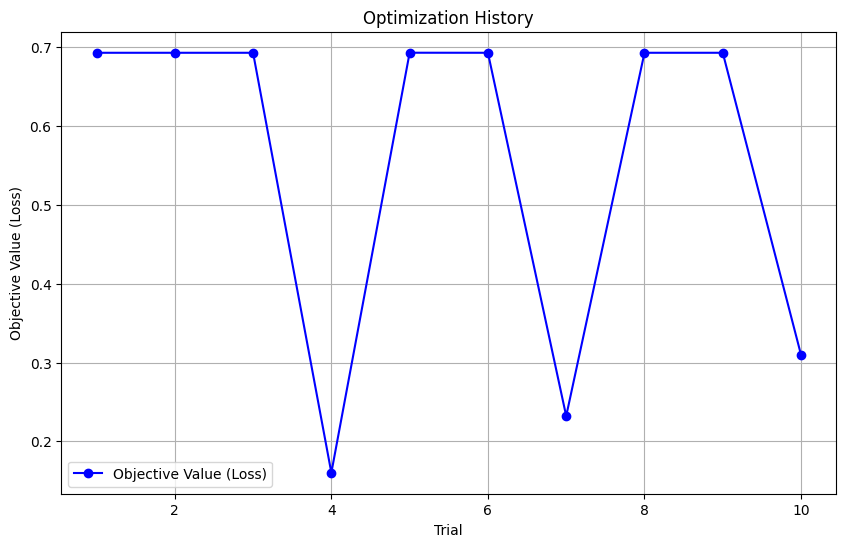

In [56]:
history = [trial.value for trial in study.trials] 


plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history) + 1), history, marker='o', color='b', label='Objective Value (Loss)')
plt.xlabel('Trial')
plt.ylabel('Objective Value (Loss)')
plt.title('Optimization History')
plt.grid(True)
plt.legend()
plt.show()

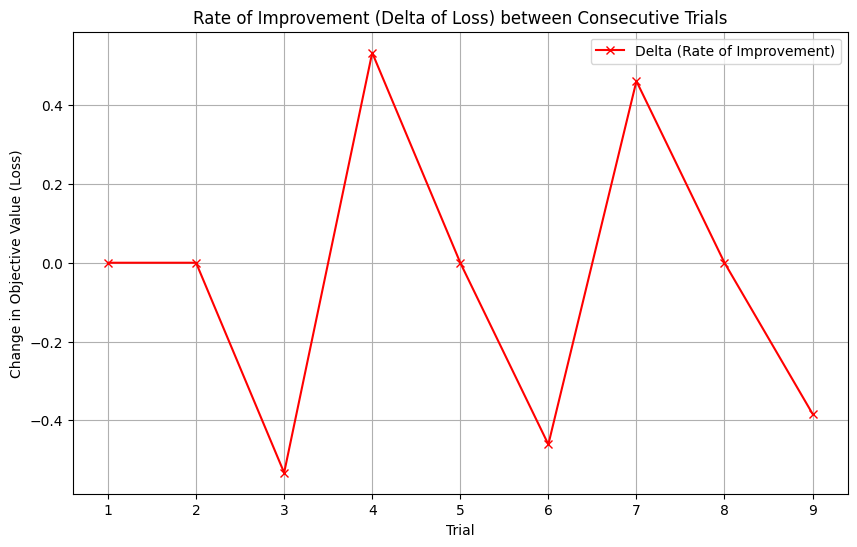

In [61]:
delta_history = np.diff(history)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(delta_history) + 1), delta_history, marker='x', color='r', label='Delta (Rate of Improvement)')
plt.xlabel('Trial')
plt.ylabel('Change in Objective Value (Loss)')
plt.title('Rate of Improvement (Delta of Loss) between Consecutive Trials')
plt.grid(True)
plt.legend()
plt.show()

# Train, evaluate and Test functions.


In [16]:
from torch.utils.data import DataLoader, ConcatDataset, Subset

def train_model(model, combined_dataset, criterion, optimizer, num_epochs=10, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    
    fold_metrics = {
        "train_losses": [],
        "valid_losses": [],
        "train_accuracies": [],
        "valid_accuracies": [],
        "precisions": [],
        "recalls": [],
        "best_accuracy": []
    }

    for fold, (train_idx, valid_idx) in enumerate(kfold.split(combined_dataset)):
        print(f"\nFold {fold+1}/{k}")

        
        train_subset = Subset(combined_dataset, train_idx)
        valid_subset = Subset(combined_dataset, valid_idx)

        train_loader = DataLoader(train_subset, batch_size=200, shuffle=True)
        valid_loader = DataLoader(valid_subset, batch_size=200, shuffle=False)

        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
    
        
        model = model.to(device)
        criterion = criterion.to(device)

        best_val_accuracy = 0.0
        fold_precision = 0
        fold_recall = 0

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            
            with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch", total=len(train_loader)) as tepoch:
                for inputs, labels in tepoch:
                    inputs, labels = inputs.to(device), labels.to(device)
                    labels = labels.float()  # Ensure labels are float for BCEWithLogitsLoss

                    optimizer.zero_grad()

                    # Forward pass
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels) 

                    # Backward pass and optimization
                    loss.backward()
                    optimizer.step()

                    # Track training statistics
                    running_loss += loss.item()
                    preds = torch.round(torch.sigmoid(outputs))
                    correct += (preds.squeeze() == labels).sum().item()
                    total += labels.size(0)

                    # Update progress bar
                    tepoch.set_postfix(loss=running_loss / (tepoch.n + 1), accuracy=correct / total * 100)

            
            train_accuracy = correct / total * 100
            fold_metrics["train_losses"].append(running_loss / len(train_loader))
            fold_metrics["train_accuracies"].append(train_accuracy)

            print(f"Train Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%") 

            # Validation loop with tqdm progress bar
            model.eval()
            correct = 0
            total = 0
            running_valid_loss = 0.0
            all_preds = []
            all_labels = []
            with tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit="batch", total=len(valid_loader)) as vepoch:
                with torch.no_grad():
                    for inputs, labels in vepoch:
                        inputs, labels = inputs.to(device), labels.to(device)
                        labels = labels.float()  # Ensure labels are float for BCEWithLogitsLoss
                        outputs = model(inputs)
                        loss = criterion(outputs.squeeze(), labels)

                        running_valid_loss += loss.item()

                        preds = torch.round(torch.sigmoid(outputs))
                        correct += (preds.squeeze() == labels).sum().item()
                        total += labels.size(0)

                        all_preds.extend(preds.squeeze().cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())

                        # Update progress bar
                        vepoch.set_postfix(loss=running_valid_loss / (vepoch.n + 1), accuracy=correct / total * 100)

                val_accuracy = correct / total * 100
                fold_metrics["valid_losses"].append(running_valid_loss / len(valid_loader))
                fold_metrics["valid_accuracies"].append(val_accuracy)

            
            precision = precision_score(all_labels, all_preds)
            recall = recall_score(all_labels, all_preds)
            fold_precision += precision
            fold_recall += recall

            print(f"Validation Accuracy: {val_accuracy:.2f}%")
            print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

            # Save the best model based on validation accuracy
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                torch.save(model.state_dict(), f"best_model_fold_{fold+1}.pth")

        
        fold_metrics["best_accuracy"].append(best_val_accuracy)
        fold_metrics["precisions"].append(fold_precision / num_epochs)
        fold_metrics["recalls"].append(fold_recall / num_epochs)

    
    avg_train_loss = sum(fold_metrics["train_losses"]) / len(fold_metrics["train_losses"])
    avg_valid_loss = sum(fold_metrics["valid_losses"]) / len(fold_metrics["valid_losses"])
    avg_train_accuracy = sum(fold_metrics["train_accuracies"]) / len(fold_metrics["train_accuracies"])
    avg_valid_accuracy = sum(fold_metrics["valid_accuracies"]) / len(fold_metrics["valid_accuracies"])
    avg_precision = sum(fold_metrics["precisions"]) / len(fold_metrics["precisions"])
    avg_recall = sum(fold_metrics["recalls"]) / len(fold_metrics["recalls"])
    avg_best_accuracy = sum(fold_metrics["best_accuracy"]) / len(fold_metrics["best_accuracy"])

    print(f"\nAverage Train Loss: {avg_train_loss:.4f}, Average Train Accuracy: {avg_train_accuracy:.2f}%")
    print(f"Average Validation Loss: {avg_valid_loss:.4f}, Average Validation Accuracy: {avg_valid_accuracy:.2f}%")
    print(f"Average Precision: {avg_precision:.2f}, Average Recall: {avg_recall:.2f}")
    print(f"Average Best Validation Accuracy: {avg_best_accuracy:.2f}%")

    return model, fold_metrics



def test_model(model, test_loader):
    model.eval() 
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing", unit="batch", total=len(test_loader)):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)  
            preds = torch.round(torch.sigmoid(outputs))  # Binary predictions (0 or 1)

            # Adjust for correct dimensions
            all_preds.extend(preds.squeeze(1).cpu().numpy())  
            all_labels.extend(labels.cpu().numpy()) 

            correct += (preds.squeeze(1) == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100
    print(f"Test Accuracy: {accuracy:.2f}%")

    return all_preds, all_labels


# Train the model using 3 folds using **Kfold** and **2 epochs**.

In [18]:
# BEST_LR_VGG=study.best_params['lr']

BEST_LR_VGG=0.00010451959580052452
vgg16 = SmallVGG()
vgg16.to(device)

criterion = nn.BCEWithLogitsLoss()  # For binary classification

optimizer = optim.Adam(vgg16.parameters(),lr=BEST_LR_VGG)

mname="vgg"

trained_vgg16,fold_matrix=train_model(vgg16,conc_dataset, criterion, optimizer, num_epochs=2, k=3)


Fold 1/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [04:39<00:00,  1.43batch/s, accuracy=84.9, loss=0.334]


Train Loss: 0.3340, Train Accuracy: 84.87%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:57<00:00,  1.70batch/s, accuracy=89, loss=0.263]  


Validation Accuracy: 88.96%
Precision: 0.83, Recall: 0.98


Epoch 2/2: 100%|██████████| 400/400 [04:38<00:00,  1.44batch/s, accuracy=94.9, loss=0.131]


Train Loss: 0.1308, Train Accuracy: 94.92%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:48<00:00,  1.84batch/s, accuracy=94.8, loss=0.132]


Validation Accuracy: 94.76%
Precision: 0.93, Recall: 0.97

Fold 2/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [04:38<00:00,  1.44batch/s, accuracy=96.5, loss=0.0948]


Train Loss: 0.0948, Train Accuracy: 96.48%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:49<00:00,  1.82batch/s, accuracy=97.5, loss=0.064] 


Validation Accuracy: 97.53%
Precision: 0.99, Recall: 0.96


Epoch 2/2: 100%|██████████| 400/400 [04:38<00:00,  1.44batch/s, accuracy=98.5, loss=0.0419]


Train Loss: 0.0419, Train Accuracy: 98.47%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:49<00:00,  1.82batch/s, accuracy=97.9, loss=0.0609]


Validation Accuracy: 97.88%
Precision: 0.97, Recall: 0.99

Fold 3/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [04:38<00:00,  1.44batch/s, accuracy=98.5, loss=0.0419]


Train Loss: 0.0419, Train Accuracy: 98.51%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:47<00:00,  1.85batch/s, accuracy=99.5, loss=0.0142]


Validation Accuracy: 99.55%
Precision: 1.00, Recall: 1.00


Epoch 2/2: 100%|██████████| 400/400 [04:40<00:00,  1.43batch/s, accuracy=99.1, loss=0.0248]


Train Loss: 0.0248, Train Accuracy: 99.12%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:51<00:00,  1.80batch/s, accuracy=98.5, loss=0.0391]

Validation Accuracy: 98.46%
Precision: 1.00, Recall: 0.97

Average Train Loss: 0.1114, Average Train Accuracy: 95.39%
Average Validation Loss: 0.0955, Average Validation Accuracy: 96.19%
Average Precision: 0.95, Average Recall: 0.98
Average Best Validation Accuracy: 97.40%


In [19]:
# Testing the model
test_preds_vgg, test_labels_vgg = test_model(trained_vgg16, test_loader)
# Save the model state_dict (recommended approach)
torch.save(trained_vgg16.state_dict(), "vgg16_trained.pth")
print("Model saved successfully as vgg16_trained.pth")

Testing: 100%|██████████| 20000/20000 [01:19<00:00, 252.72batch/s]


Test Accuracy: 95.69%
Model saved successfully as vgg16_trained.pth


In [17]:
import matplotlib.pyplot as plt

def plot_fold_metrics(train_losses,valid_losses,train_accuracies,valid_accuracies,precisions,recalls,best_accuracies):
    # Extract the metrics
    # train_losses = fold_metrics["train_losses"]
    # valid_losses = fold_metrics["valid_losses"]
    # train_accuracies = fold_metrics["train_accuracies"]
    # valid_accuracies = fold_metrics["valid_accuracies"]
    # precisions = fold_metrics["precisions"]
    # recalls = fold_metrics["recalls"]
    # best_accuracies = fold_metrics["best_accuracy"]

    # Create subplots for the metrics
    fig, ax = plt.subplots(3, 2, figsize=(14, 18))

    # Plot training and validation loss
    ax[0, 0].plot(train_losses, label="Training Loss", color="blue")
    ax[0, 0].plot(valid_losses, label="Validation Loss", color="red")
    ax[0, 0].set_title("Loss over Epochs")
    ax[0, 0].set_xlabel("Epochs")
    ax[0, 0].set_ylabel("Loss")
    ax[0, 0].legend()

    # Plot training and validation accuracy
    ax[0, 1].plot(train_accuracies, label="Training Accuracy", color="blue")
    ax[0, 1].plot(valid_accuracies, label="Validation Accuracy", color="red")
    ax[0, 1].set_title("Accuracy over Epochs")
    ax[0, 1].set_xlabel("Epochs")
    ax[0, 1].set_ylabel("Accuracy (%)")
    ax[0, 1].legend()

    # Plot precision
    ax[1, 0].plot(precisions, label="Precision", color="green", marker="o")
    ax[1, 0].set_title("Precision over Folds")
    ax[1, 0].set_xlabel("Folds")
    ax[1, 0].set_ylabel("Precision")
    ax[1, 0].legend()

    # Plot recall
    ax[1, 1].plot(recalls, label="Recall", color="orange", marker="o")
    ax[1, 1].set_title("Recall over Folds")
    ax[1, 1].set_xlabel("Folds")
    ax[1, 1].set_ylabel("Recall")
    ax[1, 1].legend()

    # Plot best accuracy
    ax[2, 0].plot(best_accuracies, label="Best Accuracy per Fold", color="purple", marker="o")
    ax[2, 0].set_title("Best Validation Accuracy per Fold")
    ax[2, 0].set_xlabel("Folds")
    ax[2, 0].set_ylabel("Accuracy (%)")
    ax[2, 0].legend()

    # Hide unused subplot
    ax[2, 1].axis("off")

    plt.tight_layout()
    plt.show()

{'train_losses': [0.3339705818146467, 0.13079762716777624, 0.0948023051675409, 0.041930963314371184, 0.04193349983077496, 0.024781180372228845], 'valid_losses': [0.2627085260674357, 0.1321416175737977, 0.06400066314497962, 0.06087798168882728, 0.014163686559768393, 0.03909613171184901], 'train_accuracies': [84.86749999999999, 94.9225, 96.47875, 98.4675, 98.51375, 99.11625], 'valid_accuracies': [88.96, 94.7575, 97.53, 97.8825, 99.5475, 98.4575], 'precisions': [0.8789266077364364, 0.9799372257131538, 0.9969648185609714], 'recalls': [0.9759102244389027, 0.9742946078923587, 0.983102036741214], 'best_accuracy': [94.7575, 97.8825, 99.5475]}


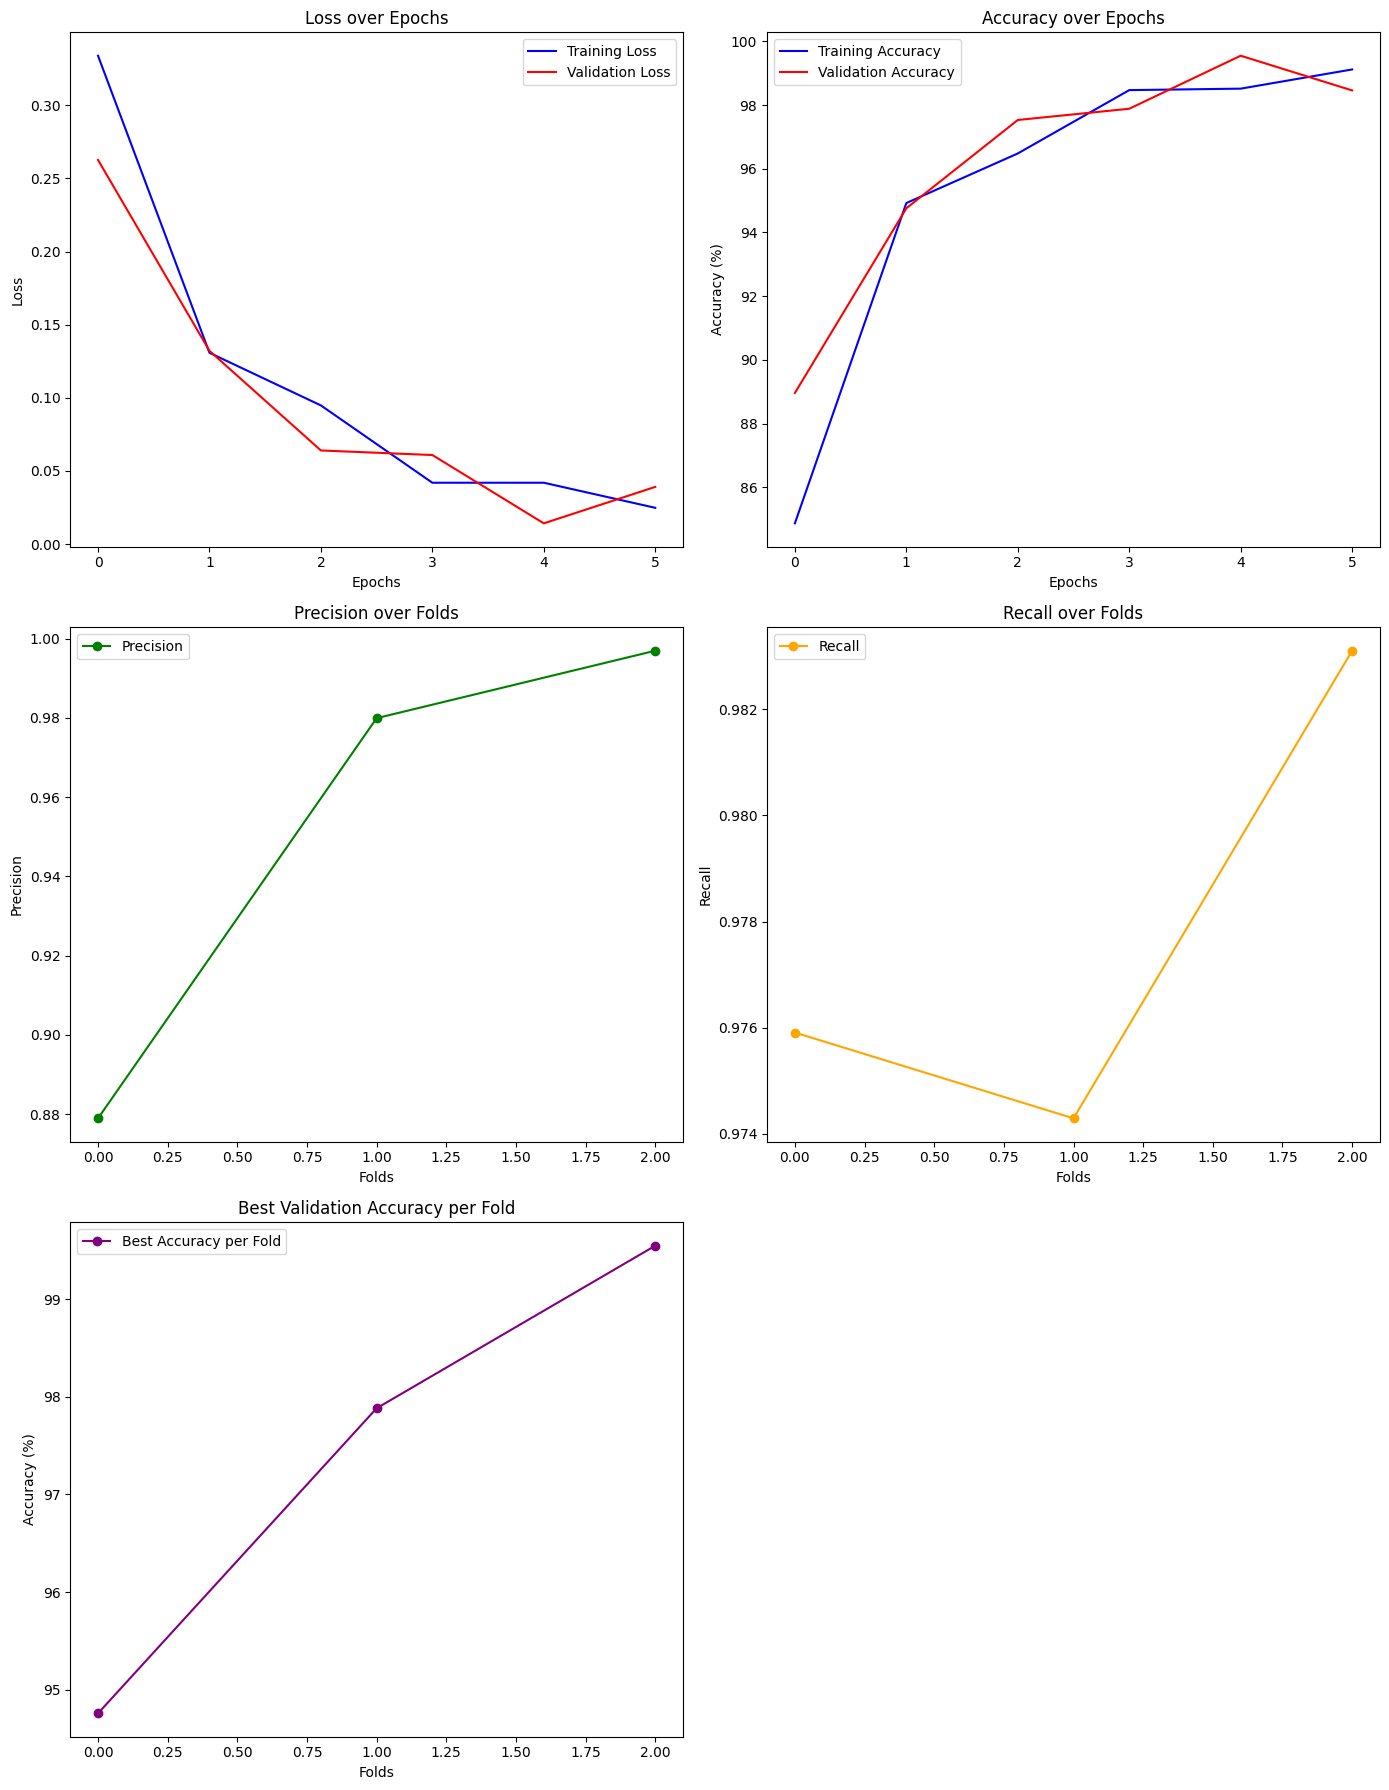

In [46]:
# Assuming fold_matrix is returned from the train_model function for the VGG16
print(fold_matrix)

plot_fold_metrics(
    train_losses=fold_matrix["train_losses"],
    valid_losses=fold_matrix["valid_losses"],
    train_accuracies=fold_matrix["train_accuracies"],
    valid_accuracies=fold_matrix["valid_accuracies"],
    precisions=fold_matrix["precisions"],
    recalls=fold_matrix["recalls"],
    best_accuracies=fold_matrix["best_accuracy"]
)


# Modified AlexNet

The SmallAlexNet model leverages the pre-trained AlexNet architecture for transfer learning, reusing its feature extraction layers to save computational resources and training time. \
The classifier is redesigned to handle binary classification by replacing the original 1,000-class output with a single-node output, tailored for the deepfake detection task \.
Input images are resized to 64×64 to reduce computational load and adapt to dataset constraints, while maintaining enough detail for feature extractio \n.
Flattening the feature map output ensures compatibility with the custom fully connected layers, optimizing the model for your specific application.

In [46]:
import torch
import torch.nn as nn
from torchvision import models

class SmallAlexNet(nn.Module):
    def __init__(self):
        super(SmallAlexNet, self).__init__()
        alexnet = models.alexnet(weights='IMAGENET1K_V1')
        self.features = alexnet.features

        # Use a fixed input size for 64x64 images (calculated manually or using a forward pass).
        self.classifier = nn.Sequential(
            nn.Linear(256, 4096),  # Adjusted for AlexNet features and 64x64 input size
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1)  # Output for binary classification
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten dynamically
        x = self.classifier(x)
        return x


# class SmallAlexNet(nn.Module):
#     def __init__(self):
#         super(SmallAlexNet, self).__init__()
#         # Load AlexNet with pretrained weights
#         alexnet = models.alexnet(weights='IMAGENET1K_V1')
#         self.features = alexnet.features  # Use AlexNet's convolutional layers

#         # Classifier adapted for smaller input size and binary classification
#         self.classifier = nn.Sequential(
#             nn.Linear(256, 512),  # Smaller hidden layer
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(512, 256),  # Another smaller hidden layer
#             nn.ReLU(True),
#             nn.Dropout(),
#             nn.Linear(256, 1)  # Output for binary classification
#         )
    
#     def forward(self, x):
#         # Pass through the feature extractor
#         x = self.features(x)

#         # Flatten dynamically
#         x = torch.flatten(x, 1)

#         # Pass through the classifier
#         x = self.classifier(x)
#         return x


# Objective for Small AlexNet

In [40]:
def objective(trial):
    # Sample hyperparameters
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)  # Learning rate (log scale)

    # Initialize the model, loss, and optimizer
    model = SmallAlexNet()
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Determine the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Move the model and criterion to the device
    model = model.to(device)
    criterion = criterion.to(device)
    
    print(f"Trial: {trial.number} with learning rate: {lr}")

    # Training loop
    model.train()
    with tqdm(train_loader, desc=f"Train Trial: {trial.number}", unit="batch", total=len(train_loader)) as tepoch:
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)  # Ensure labels are float and shaped correctly

            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Update the progress bar with the loss value
            tepoch.set_postfix(loss=loss.item())

    # Validation loop
    model.eval()
    val_loss = 0.0
    with tqdm(val_loader, desc=f"Validate Trial: {trial.number}", unit="batch", total=len(val_loader)) as tepoch:
        with torch.no_grad():
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)  # Ensure labels are float and shaped correctly
            
                outputs = model(inputs)
                loss = criterion(outputs, labels)  # Compute loss during validation
                val_loss += loss.item()  # Accumulate the loss
                
                # Update the progress bar with the loss value
                tepoch.set_postfix(loss=loss.item())
        
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)
    print(f"Trial: {trial.number} with validation loss: {avg_val_loss}")
    
    return avg_val_loss  # We aim to minimize the validation loss

In [41]:
# Create a study object to optimize the objective function
import optuna
study = optuna.create_study(direction="minimize")  # We want to maximize the accuracy

# Optimize the objective function with a given number of trials
study.optimize(objective, n_trials=10)  # Number of trials (evaluations)

# After optimization, you can print the best hyperparameters found
print("Best hyperparameters:", study.best_params)

[I 2024-12-05 03:54:06,999] A new study created in memory with name: no-name-8aeb8a12-addd-4b3c-bb04-408eeed8dd0a
/tmp/ipykernel_23/3338249414.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)  # Learning rate (log scale)


Using device: cuda
Trial: 0 with learning rate: 0.0004423313948692377


Validate Trial: 0: 100%|██████████| 100/100 [00:27<00:00,  3.60batch/s, loss=0.261]
[I 2024-12-05 03:56:56,767] Trial 0 finished with value: 0.41679571628570555 and parameters: {'lr': 0.0004423313948692377}. Best is trial 0 with value: 0.41679571628570555.


Trial: 0 with validation loss: 0.41679571628570555
Using device: cuda
Trial: 1 with learning rate: 0.02308607233313103


Validate Trial: 1: 100%|██████████| 100/100 [00:27<00:00,  3.64batch/s, loss=0.689]
[I 2024-12-05 03:59:45,160] Trial 1 finished with value: 0.6931546628475189 and parameters: {'lr': 0.02308607233313103}. Best is trial 0 with value: 0.41679571628570555.


Trial: 1 with validation loss: 0.6931546628475189
Using device: cuda
Trial: 2 with learning rate: 0.09111585389378746


Validate Trial: 2: 100%|██████████| 100/100 [00:27<00:00,  3.57batch/s, loss=0.709]
[I 2024-12-05 04:02:34,593] Trial 2 finished with value: 0.6932440400123596 and parameters: {'lr': 0.09111585389378746}. Best is trial 0 with value: 0.41679571628570555.


Trial: 2 with validation loss: 0.6932440400123596
Using device: cuda
Trial: 3 with learning rate: 0.012439865953242297


Validate Trial: 3: 100%|██████████| 100/100 [00:28<00:00,  3.49batch/s, loss=0.691]
[I 2024-12-05 04:05:23,445] Trial 3 finished with value: 0.693150669336319 and parameters: {'lr': 0.012439865953242297}. Best is trial 0 with value: 0.41679571628570555.


Trial: 3 with validation loss: 0.693150669336319
Using device: cuda
Trial: 4 with learning rate: 0.0013291354706783112


Validate Trial: 4: 100%|██████████| 100/100 [00:27<00:00,  3.59batch/s, loss=0.4] 
[I 2024-12-05 04:08:11,101] Trial 4 finished with value: 0.4046779000759125 and parameters: {'lr': 0.0013291354706783112}. Best is trial 4 with value: 0.4046779000759125.


Trial: 4 with validation loss: 0.4046779000759125
Using device: cuda
Trial: 5 with learning rate: 2.2112291627623788e-05


Validate Trial: 5: 100%|██████████| 100/100 [00:27<00:00,  3.57batch/s, loss=0.536]
[I 2024-12-05 04:11:00,312] Trial 5 finished with value: 0.5223779380321503 and parameters: {'lr': 2.2112291627623788e-05}. Best is trial 4 with value: 0.4046779000759125.


Trial: 5 with validation loss: 0.5223779380321503
Using device: cuda
Trial: 6 with learning rate: 0.005802160242631222


Validate Trial: 6: 100%|██████████| 100/100 [00:27<00:00,  3.58batch/s, loss=0.693]
[I 2024-12-05 04:13:50,263] Trial 6 finished with value: 0.6931471824645996 and parameters: {'lr': 0.005802160242631222}. Best is trial 4 with value: 0.4046779000759125.


Trial: 6 with validation loss: 0.6931471824645996
Using device: cuda
Trial: 7 with learning rate: 0.04099007065269696


Validate Trial: 7: 100%|██████████| 100/100 [00:27<00:00,  3.60batch/s, loss=0.687]
[I 2024-12-05 04:16:39,242] Trial 7 finished with value: 0.697550641298294 and parameters: {'lr': 0.04099007065269696}. Best is trial 4 with value: 0.4046779000759125.


Trial: 7 with validation loss: 0.697550641298294
Using device: cuda
Trial: 8 with learning rate: 0.018641746195573405


Validate Trial: 8: 100%|██████████| 100/100 [00:28<00:00,  3.49batch/s, loss=0.694]
[I 2024-12-05 04:19:27,311] Trial 8 finished with value: 0.6931474804878235 and parameters: {'lr': 0.018641746195573405}. Best is trial 4 with value: 0.4046779000759125.


Trial: 8 with validation loss: 0.6931474804878235
Using device: cuda
Trial: 9 with learning rate: 0.0005837955954038364


Validate Trial: 9: 100%|██████████| 100/100 [00:28<00:00,  3.55batch/s, loss=0.41]
[I 2024-12-05 04:22:16,467] Trial 9 finished with value: 0.39758147805929184 and parameters: {'lr': 0.0005837955954038364}. Best is trial 9 with value: 0.39758147805929184.


Trial: 9 with validation loss: 0.39758147805929184
Best hyperparameters: {'lr': 0.0005837955954038364}


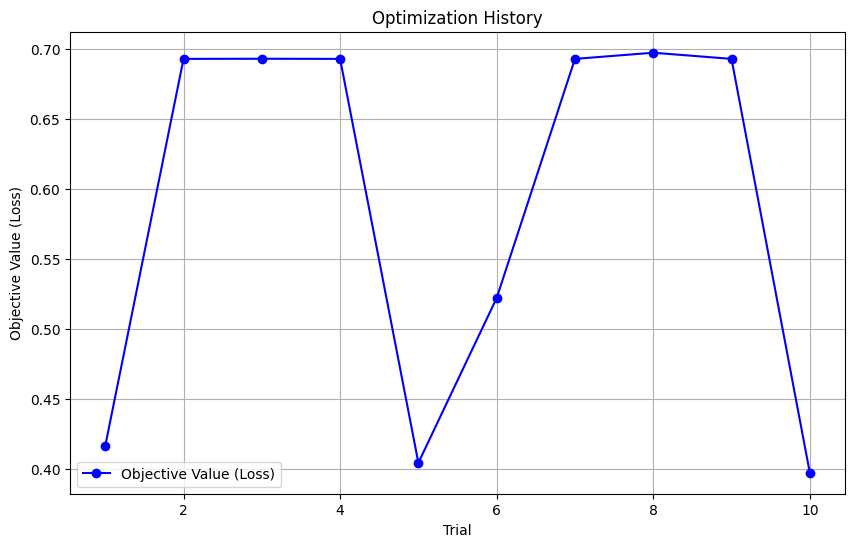

In [42]:
history = [trial.value for trial in study.trials]  # List of objective values (loss in your case)

# Plot the optimization history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history) + 1), history, marker='o', color='b', label='Objective Value (Loss)')
plt.xlabel('Trial')
plt.ylabel('Objective Value (Loss)')
plt.title('Optimization History')
plt.grid(True)
plt.legend()
plt.show()

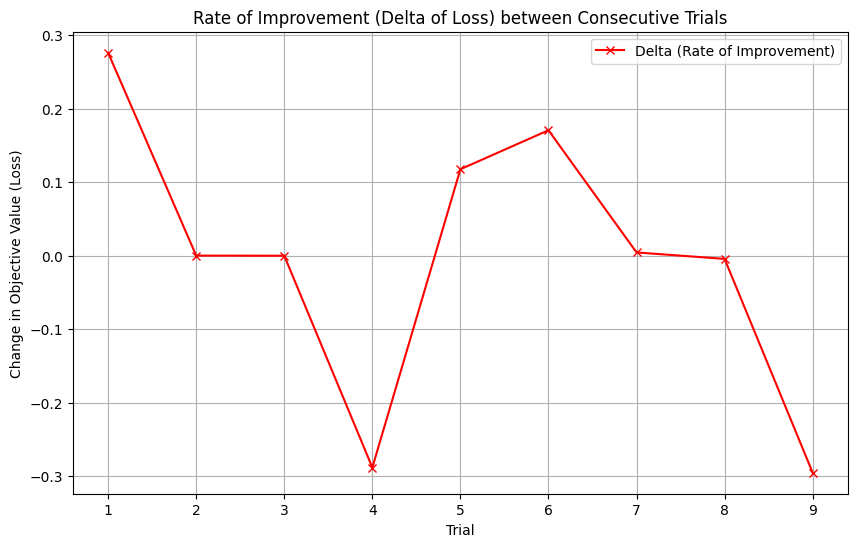

In [43]:
# Calculate the delta between consecutive trials
delta_history = np.diff(history)

# Plotting the rate of improvement (delta of objective values)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(delta_history) + 1), delta_history, marker='x', color='r', label='Delta (Rate of Improvement)')
plt.xlabel('Trial')
plt.ylabel('Change in Objective Value (Loss)')
plt.title('Rate of Improvement (Delta of Loss) between Consecutive Trials')
plt.grid(True)
plt.legend()
plt.show()

In [47]:
BEST_LR_AlexNet=study.best_params['lr']
alex_net = SmallAlexNet()
alex_net.to(device)

criterion = nn.BCEWithLogitsLoss()  # For binary classification

optimizer = optim.Adam(alex_net.parameters(),lr=BEST_LR_AlexNet)

mname="alex net"

trained_alex,fold_metrics=train_model(alex_net,conc_dataset, criterion, optimizer, num_epochs=2, k=3)


Fold 1/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:36<00:00,  1.85batch/s, accuracy=73.1, loss=0.537]


Train Loss: 0.5374, Train Accuracy: 73.09%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:43<00:00,  1.93batch/s, accuracy=76.3, loss=0.508]


Validation Accuracy: 76.25%
Precision: 0.70, Recall: 0.92


Epoch 2/2: 100%|██████████| 400/400 [03:37<00:00,  1.84batch/s, accuracy=82.3, loss=0.394]


Train Loss: 0.3936, Train Accuracy: 82.30%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:43<00:00,  1.94batch/s, accuracy=83.4, loss=0.37] 


Validation Accuracy: 83.36%
Precision: 0.88, Recall: 0.78

Fold 2/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:39<00:00,  1.82batch/s, accuracy=85.4, loss=0.336]


Train Loss: 0.3362, Train Accuracy: 85.44%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:44<00:00,  1.92batch/s, accuracy=87.7, loss=0.285]


Validation Accuracy: 87.71%
Precision: 0.88, Recall: 0.87


Epoch 2/2: 100%|██████████| 400/400 [03:38<00:00,  1.83batch/s, accuracy=88.4, loss=0.276]


Train Loss: 0.2758, Train Accuracy: 88.41%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:42<00:00,  1.95batch/s, accuracy=89.1, loss=0.262]


Validation Accuracy: 89.09%
Precision: 0.86, Recall: 0.93

Fold 3/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [03:36<00:00,  1.85batch/s, accuracy=89.7, loss=0.248]


Train Loss: 0.2477, Train Accuracy: 89.72%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:43<00:00,  1.93batch/s, accuracy=91.6, loss=0.203]


Validation Accuracy: 91.59%
Precision: 0.90, Recall: 0.94


Epoch 2/2: 100%|██████████| 400/400 [03:37<00:00,  1.84batch/s, accuracy=91.7, loss=0.204]


Train Loss: 0.2040, Train Accuracy: 91.74%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:43<00:00,  1.93batch/s, accuracy=90.5, loss=0.233]

Validation Accuracy: 90.49%
Precision: 0.86, Recall: 0.97

Average Train Loss: 0.3324, Average Train Accuracy: 85.12%
Average Validation Loss: 0.3101, Average Validation Accuracy: 86.42%
Average Precision: 0.85, Average Recall: 0.90
Average Best Validation Accuracy: 88.01%


In [48]:
# Testing the model
test_preds_alex, test_labels_alex = test_model(trained_alex, test_loader)
# Save the model state_dict (recommended approach)
torch.save(trained_alex.state_dict(), "AlexNet_trained.pth")
print("Model saved successfully as AlexNet_trained.pth")

Testing: 100%|██████████| 20000/20000 [01:25<00:00, 234.82batch/s]


Test Accuracy: 88.39%
Model saved successfully as AlexNet_trained.pth


{'train_losses': [0.5374116045236588, 0.39355261087417603, 0.3361925331503153, 0.27578110318630933, 0.24766069799661636, 0.20403478117659687], 'valid_losses': [0.5077734635025263, 0.3696170787513256, 0.2854115504026413, 0.2621202100813389, 0.20258138094097375, 0.23293140664696693], 'train_accuracies': [73.09375, 82.30375, 85.4375, 88.41250000000001, 89.72375, 91.74125], 'valid_accuracies': [76.2525, 83.36, 87.7125, 89.0925, 91.59, 90.4875], 'precisions': [0.7877497230214419, 0.8744088084763005, 0.8782490658019013], 'recalls': [0.8511221945137157, 0.8963751380660709, 0.9546725239616614], 'best_accuracy': [83.36, 89.0925, 91.59]}


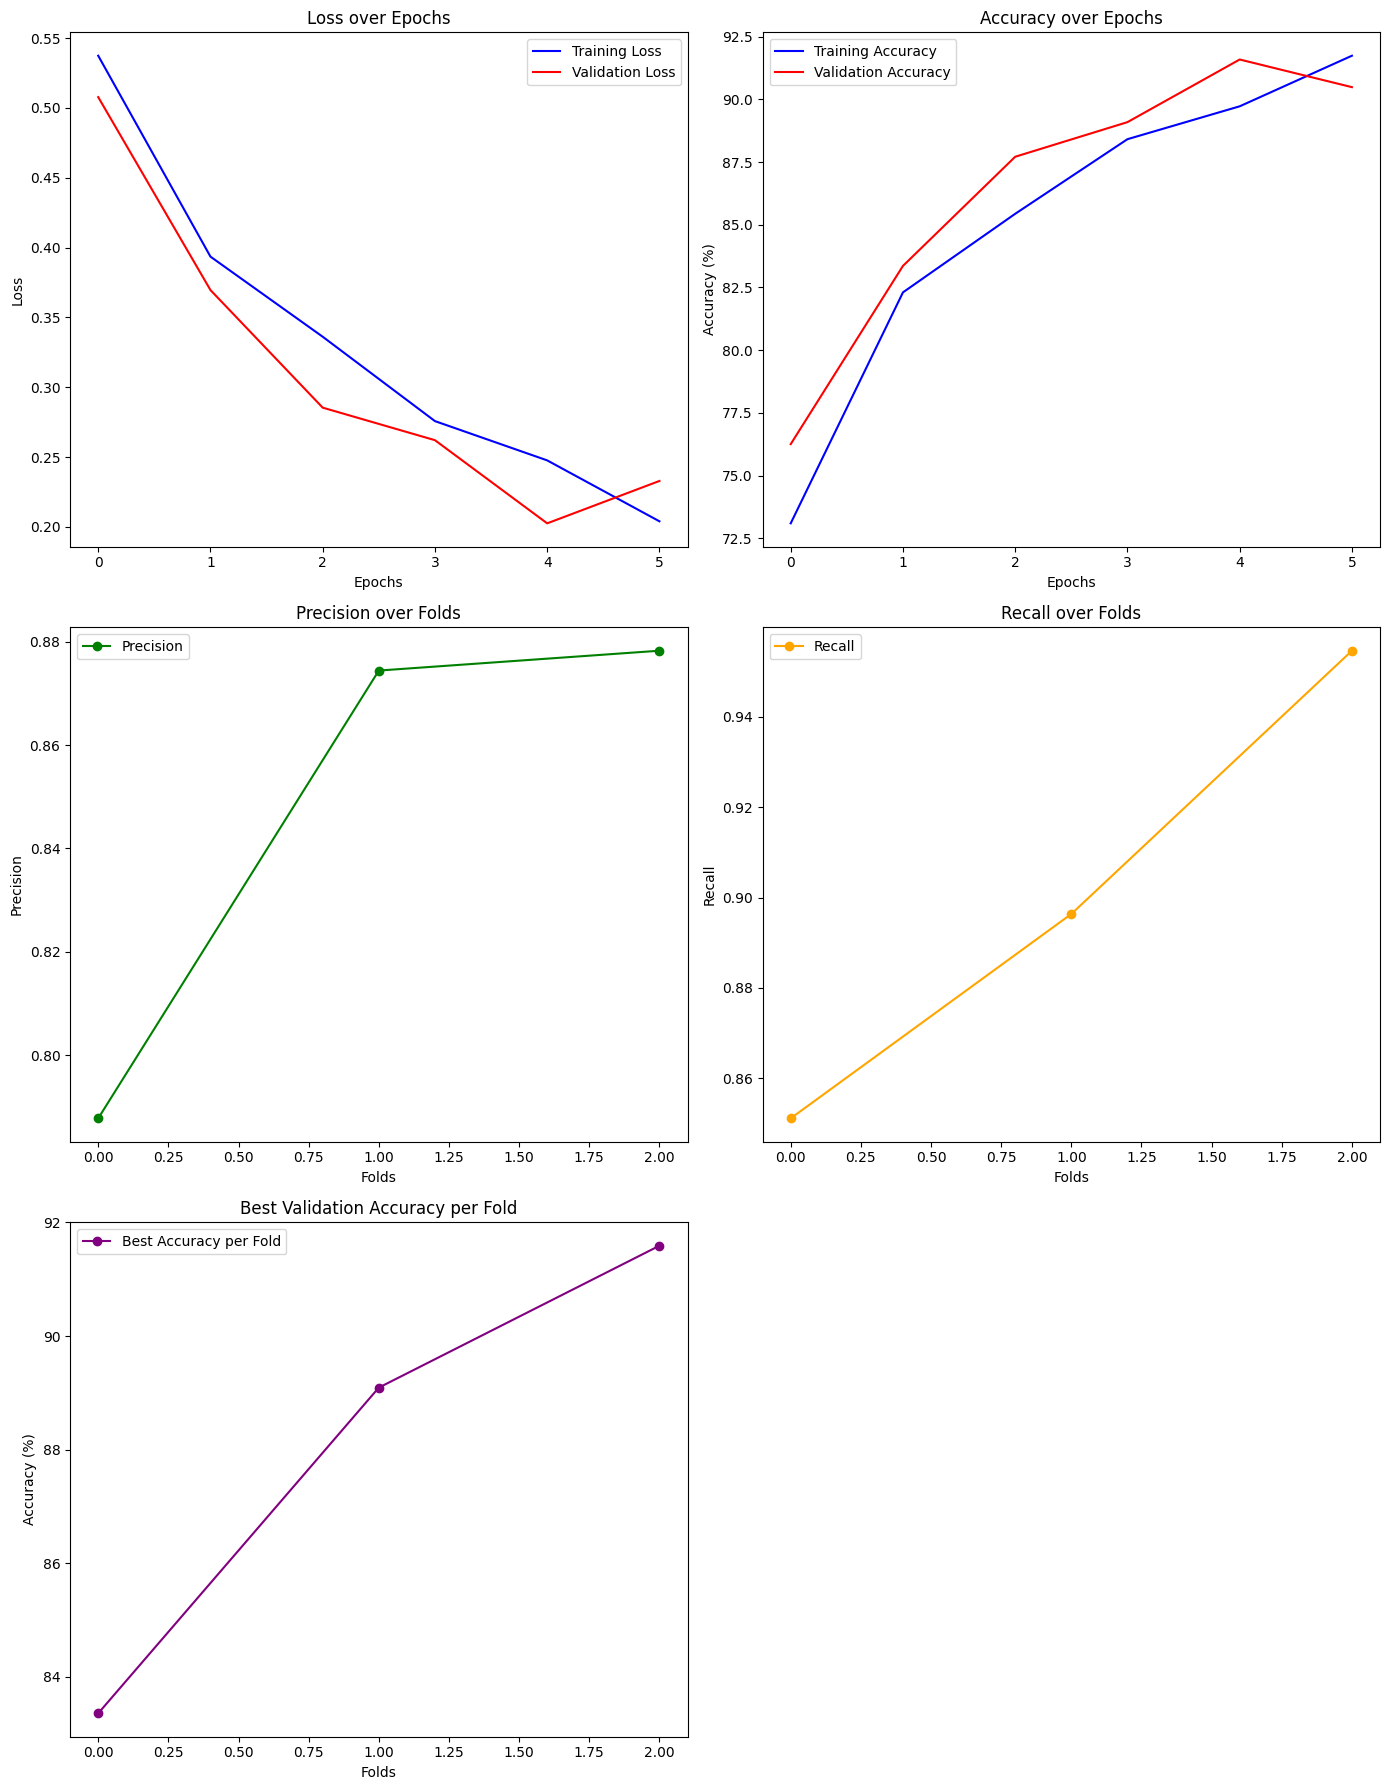

In [52]:
print(fold_metrics)

plot_fold_metrics(
    train_losses=fold_metrics["train_losses"],
    valid_losses=fold_metrics["valid_losses"],
    train_accuracies=fold_metrics["train_accuracies"],
    valid_accuracies=fold_metrics["valid_accuracies"],
    precisions=fold_metrics["precisions"],
    recalls=fold_metrics["recalls"],
    best_accuracies=fold_metrics["best_accuracy"]
)

# Modeified ResNet18

The modified ResNet18 model leverages the pre-trained ResNet18 architecture for transfer learning, reusing its feature extraction layers to save computational resources and training time.\
The classifier is redesigned to handle binary classification by replacing the original 1,000-class output with a single-node output, tailored for the deepfake detection task\.
Input images are resized to 64×64 to reduce computational load and adapt to dataset constraints, while maintaining enough detail for feature extractio\n.
Flattening the feature map output ensures compatibility with the custom fully connected layers, optimizing the model for your specific applicati \
Note: Adjust the first convolutional layer to handle smaller input images (64x64), Original input: 224x224 -> ResNet expects a larger input, so we change the kernel sizeon.

In [58]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()

        # Load the pretrained ResNet18 model
        resnet18 = models.resnet18(weights='IMAGENET1K_V1')

        resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Replace the classifier with a binary classification output
        resnet18.fc = nn.Sequential(
            nn.Linear(resnet18.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

        self.model = resnet18

    def forward(self, x):
        return self.model(x)



model = ResNet18()

# Resnet18 Objective function

In [56]:
def objective_REsNet18(trial):
    
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-1) 

    model = ResNet18()
    criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    
    model = model.to(device)
    criterion = criterion.to(device)
    
    print(f"Trial: {trial.number} with learning rate: {lr}")

    # Training loop
    model.train()
    with tqdm(train_loader, desc=f"Train Trial: {trial.number}", unit="batch", total=len(train_loader)) as tepoch:
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Update the progress bar with the loss value
            tepoch.set_postfix(loss=loss.item())

    # Validation loop
    model.eval()
    val_loss = 0.0
    with tqdm(val_loader, desc=f"Validate Trial: {trial.number}", unit="batch", total=len(val_loader)) as tepoch:
        with torch.no_grad():
            for inputs, labels in tepoch:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)
            
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                
                tepoch.set_postfix(loss=loss.item())
        
    
    avg_val_loss = val_loss / len(val_loader)
    print(f"Trial: {trial.number} with validation loss: {avg_val_loss}")
    
    return avg_val_loss  # We aim to minimize the validation loss

In [61]:
study = optuna.create_study(direction="minimize") 

study.optimize(objective_REsNet18, n_trials=10)  

print("Best hyperparameters:", study.best_params)

[I 2024-12-05 06:13:24,992] A new study created in memory with name: no-name-67b759e1-4e43-45f8-8ca2-8ec5572f2f94
/tmp/ipykernel_23/1702655723.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-1)  # Learning rate (log scale)


Using device: cuda
Trial: 0 with learning rate: 0.0007819842838264582


Validate Trial: 0: 100%|██████████| 100/100 [00:28<00:00,  3.49batch/s, loss=0.14]
[I 2024-12-05 06:16:20,257] Trial 0 finished with value: 0.4350575774163008 and parameters: {'lr': 0.0007819842838264582}. Best is trial 0 with value: 0.4350575774163008.


Trial: 0 with validation loss: 0.4350575774163008
Using device: cuda
Trial: 1 with learning rate: 0.09889761186252671


Validate Trial: 1: 100%|██████████| 100/100 [00:28<00:00,  3.55batch/s, loss=0.747]
[I 2024-12-05 06:19:12,171] Trial 1 finished with value: 0.6944512587785721 and parameters: {'lr': 0.09889761186252671}. Best is trial 0 with value: 0.4350575774163008.


Trial: 1 with validation loss: 0.6944512587785721
Using device: cuda
Trial: 2 with learning rate: 2.3089987316545572e-05


Validate Trial: 2: 100%|██████████| 100/100 [00:27<00:00,  3.60batch/s, loss=0.493]
[I 2024-12-05 06:22:05,538] Trial 2 finished with value: 0.5329996964335442 and parameters: {'lr': 2.3089987316545572e-05}. Best is trial 0 with value: 0.4350575774163008.


Trial: 2 with validation loss: 0.5329996964335442
Using device: cuda
Trial: 3 with learning rate: 0.014217764067721864


Validate Trial: 3: 100%|██████████| 100/100 [00:28<00:00,  3.51batch/s, loss=0.697]
[I 2024-12-05 06:24:58,967] Trial 3 finished with value: 0.6931537729501724 and parameters: {'lr': 0.014217764067721864}. Best is trial 0 with value: 0.4350575774163008.


Trial: 3 with validation loss: 0.6931537729501724
Using device: cuda
Trial: 4 with learning rate: 9.037438023759518e-05


Validate Trial: 4: 100%|██████████| 100/100 [00:28<00:00,  3.57batch/s, loss=0.39]
[I 2024-12-05 06:27:54,455] Trial 4 finished with value: 0.42006547570228575 and parameters: {'lr': 9.037438023759518e-05}. Best is trial 4 with value: 0.42006547570228575.


Trial: 4 with validation loss: 0.42006547570228575
Using device: cuda
Trial: 5 with learning rate: 2.8075807328790786e-05


Validate Trial: 5: 100%|██████████| 100/100 [00:29<00:00,  3.41batch/s, loss=0.52]
[I 2024-12-05 06:30:51,031] Trial 5 finished with value: 0.516194896697998 and parameters: {'lr': 2.8075807328790786e-05}. Best is trial 4 with value: 0.42006547570228575.


Trial: 5 with validation loss: 0.516194896697998
Using device: cuda
Trial: 6 with learning rate: 0.003572346184611456


Validate Trial: 6: 100%|██████████| 100/100 [00:27<00:00,  3.66batch/s, loss=0.369]
[I 2024-12-05 06:33:47,315] Trial 6 finished with value: 0.5124917402863503 and parameters: {'lr': 0.003572346184611456}. Best is trial 4 with value: 0.42006547570228575.


Trial: 6 with validation loss: 0.5124917402863503
Using device: cuda
Trial: 7 with learning rate: 0.03705655067131553


Validate Trial: 7: 100%|██████████| 100/100 [00:28<00:00,  3.57batch/s, loss=0.684]
[I 2024-12-05 06:36:39,593] Trial 7 finished with value: 0.693192720413208 and parameters: {'lr': 0.03705655067131553}. Best is trial 4 with value: 0.42006547570228575.


Trial: 7 with validation loss: 0.693192720413208
Using device: cuda
Trial: 8 with learning rate: 0.013077391202647995


Validate Trial: 8: 100%|██████████| 100/100 [00:28<00:00,  3.48batch/s, loss=0.707]
[I 2024-12-05 06:39:33,515] Trial 8 finished with value: 0.6898305505514145 and parameters: {'lr': 0.013077391202647995}. Best is trial 4 with value: 0.42006547570228575.


Trial: 8 with validation loss: 0.6898305505514145
Using device: cuda
Trial: 9 with learning rate: 7.428714444751248e-05


Validate Trial: 9: 100%|██████████| 100/100 [00:29<00:00,  3.42batch/s, loss=0.342]
[I 2024-12-05 06:42:33,738] Trial 9 finished with value: 0.4262860906124115 and parameters: {'lr': 7.428714444751248e-05}. Best is trial 4 with value: 0.42006547570228575.


Trial: 9 with validation loss: 0.4262860906124115
Best hyperparameters: {'lr': 9.037438023759518e-05}


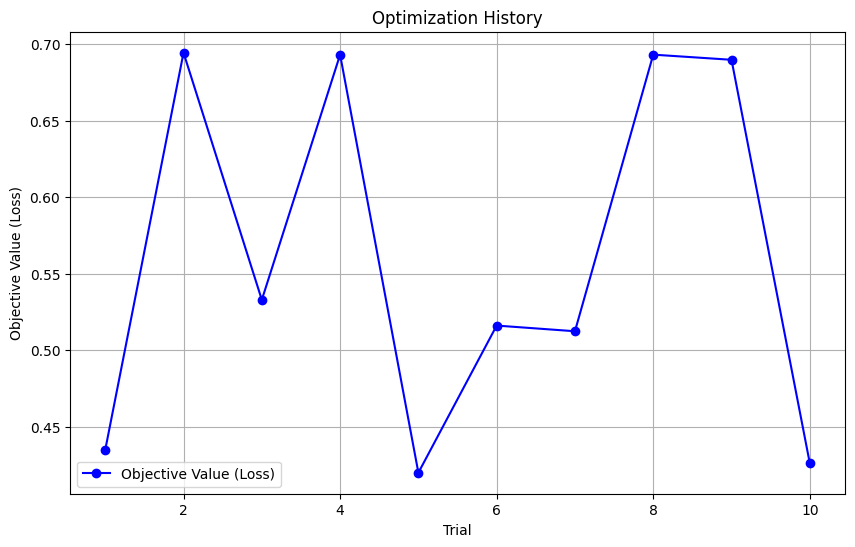

In [64]:
history = [trial.value for trial in study.trials]  # List of objective values (loss in your case)

# Plot the optimization history
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history) + 1), history, marker='o', color='b', label='Objective Value (Loss)')
plt.xlabel('Trial')
plt.ylabel('Objective Value (Loss)')
plt.title('Optimization History')
plt.grid(True)
plt.legend()
plt.show()

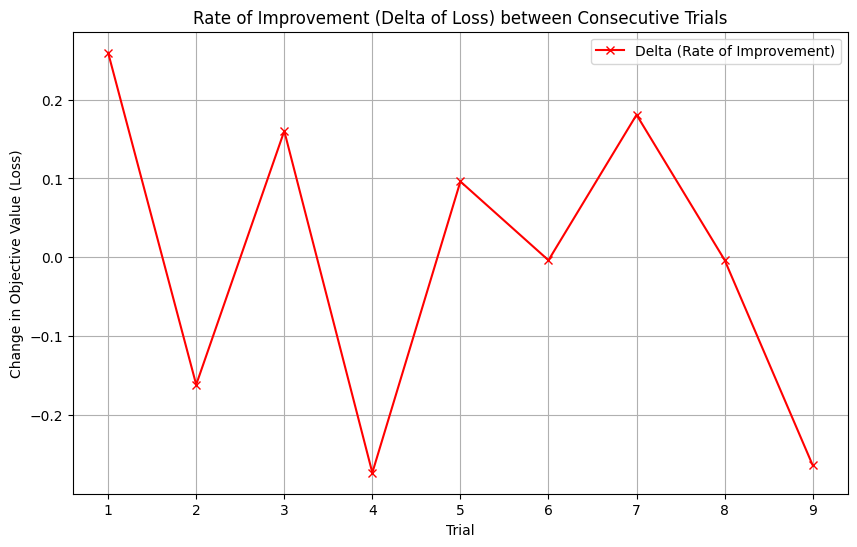

In [65]:
# Calculate the delta between consecutive trials
delta_history = np.diff(history)

# Plotting the rate of improvement (delta of objective values)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(delta_history) + 1), delta_history, marker='x', color='r', label='Delta (Rate of Improvement)')
plt.xlabel('Trial')
plt.ylabel('Change in Objective Value (Loss)')
plt.title('Rate of Improvement (Delta of Loss) between Consecutive Trials')
plt.grid(True)
plt.legend()
plt.show()

In [66]:
BEST_LR_Resnet18=study.best_params['lr']
Resnet18 = ResNet18()
Resnet18.to(device)

criterion = nn.BCEWithLogitsLoss()  # For binary classification

optimizer = optim.Adam(Resnet18.parameters(),lr=BEST_LR_Resnet18)

mname="res net"

trained_Resnet,fold_metrics=train_model(Resnet18,conc_dataset, criterion, optimizer, num_epochs=2, k=3)


Fold 1/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [04:01<00:00,  1.66batch/s, accuracy=73.6, loss=0.52] 


Train Loss: 0.5201, Train Accuracy: 73.59%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:47<00:00,  1.86batch/s, accuracy=80.3, loss=0.427]


Validation Accuracy: 80.26%
Precision: 0.77, Recall: 0.86


Epoch 2/2: 100%|██████████| 400/400 [03:59<00:00,  1.67batch/s, accuracy=85.8, loss=0.331]


Train Loss: 0.3311, Train Accuracy: 85.78%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:46<00:00,  1.87batch/s, accuracy=84.6, loss=0.36] 


Validation Accuracy: 84.61%
Precision: 0.83, Recall: 0.88

Fold 2/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [04:01<00:00,  1.66batch/s, accuracy=88.9, loss=0.269]


Train Loss: 0.2688, Train Accuracy: 88.86%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:47<00:00,  1.87batch/s, accuracy=91.6, loss=0.217]


Validation Accuracy: 91.55%
Precision: 0.94, Recall: 0.88


Epoch 2/2: 100%|██████████| 400/400 [04:00<00:00,  1.66batch/s, accuracy=94, loss=0.156]  


Train Loss: 0.1563, Train Accuracy: 93.97%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:48<00:00,  1.85batch/s, accuracy=92, loss=0.2]    


Validation Accuracy: 91.98%
Precision: 0.92, Recall: 0.92

Fold 3/3
Using device: cuda


Epoch 1/2: 100%|██████████| 400/400 [04:01<00:00,  1.66batch/s, accuracy=94.3, loss=0.15] 


Train Loss: 0.1500, Train Accuracy: 94.31%


Validation Epoch 1/2: 100%|██████████| 200/200 [01:45<00:00,  1.89batch/s, accuracy=96.4, loss=0.0986]


Validation Accuracy: 96.36%
Precision: 0.97, Recall: 0.96


Epoch 2/2: 100%|██████████| 400/400 [03:59<00:00,  1.67batch/s, accuracy=97.1, loss=0.078] 


Train Loss: 0.0780, Train Accuracy: 97.08%


Validation Epoch 2/2: 100%|██████████| 200/200 [01:45<00:00,  1.90batch/s, accuracy=96.7, loss=0.0859]

Validation Accuracy: 96.67%
Precision: 0.97, Recall: 0.97

Average Train Loss: 0.2507, Average Train Accuracy: 88.93%
Average Validation Loss: 0.2314, Average Validation Accuracy: 90.24%
Average Precision: 0.90, Average Recall: 0.91
Average Best Validation Accuracy: 91.09%


In [67]:
# Testing the model
test_preds_resnet, test_labels_alex = test_model(trained_Resnet, test_loader)
# Save the model state_dict (recommended approach)
torch.save(trained_Resnet.state_dict(), "ResNet18_trained.pth")
print("Model saved successfully as ResNet18_trained.pth")



Testing: 100%|██████████| 20000/20000 [01:47<00:00, 186.41batch/s]


Test Accuracy: 90.42%
Model saved successfully as ResNet18_trained.pth


{'train_losses': [0.5200539653748274, 0.3311351193860173, 0.2688484041765332, 0.1562706663645804, 0.1500393982231617, 0.07803251841571182], 'valid_losses': [0.42665361508727073, 0.36042128823697567, 0.21658703934401274, 0.20009067509323358, 0.09860294630751014, 0.08586736536584795], 'train_accuracies': [73.5925, 85.78125, 88.85625, 93.965, 94.3125, 97.07625], 'valid_accuracies': [80.25999999999999, 84.6075, 91.55250000000001, 91.9825, 96.365, 96.6725], 'precisions': [0.7999428330827644, 0.9297758989406675, 0.965278311710232], 'recalls': [0.8672069825436408, 0.9034792649864445, 0.9652056709265175], 'best_accuracy': [84.6075, 91.9825, 96.6725]}


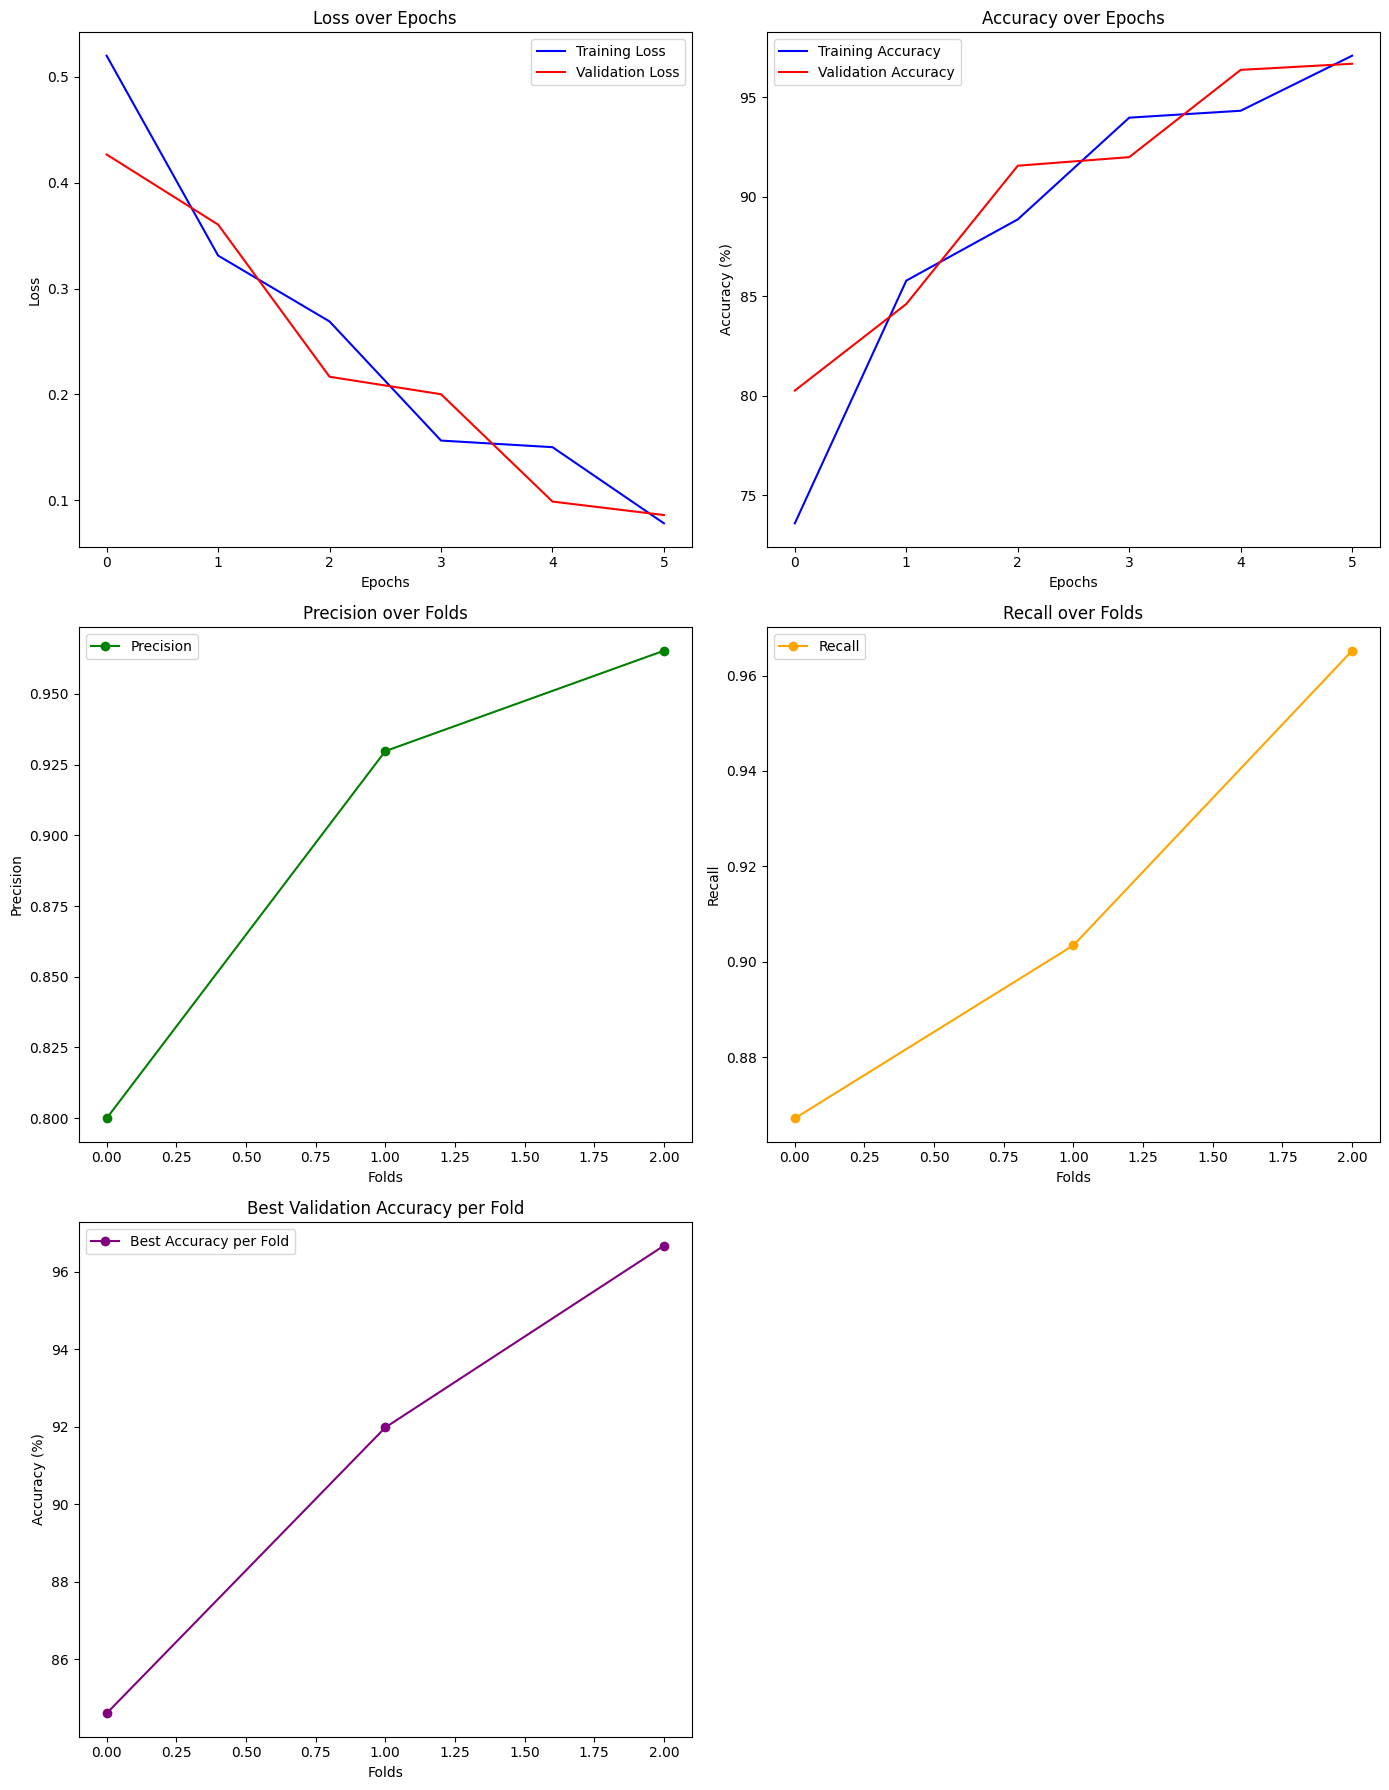

In [68]:

print(fold_metrics)

plot_fold_metrics(
    train_losses=fold_metrics["train_losses"],
    valid_losses=fold_metrics["valid_losses"],
    train_accuracies=fold_metrics["train_accuracies"],
    valid_accuracies=fold_metrics["valid_accuracies"],
    precisions=fold_metrics["precisions"],
    recalls=fold_metrics["recalls"],
    best_accuracies=fold_metrics["best_accuracy"]
)